In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statistics
import math
import scipy.integrate as integrate
import warnings
warnings.simplefilter('ignore')
from scipy import stats as sci
import derived_data as d

In [2]:
 def log_normal_pdf(x, mu, sigma):
    return (np.exp(-((x - mu)**2 / (2 * sigma**2)))) / (sigma * np.sqrt(2 * np.pi))

In [3]:
# range of potential parameter values - the fit will test each and every single one of these against one-another
# course
mu_range = np.arange(-2, 5, .1)
sigma_range = np.arange(-2, 4, .1)
A_range = np.arange(0, 1, .1)

# medium (WD split)
# mu_range = np.arange(1.3, 1.7, .01)
# sigma_range = np.arange(0.8, 1.2, .01)
# A_range = np.arange(.1, .4, .01)

# medium (WD split, no SV)
# mu_range = np.arange(1.4, 1.8, .01)
# sigma_range = np.arange(0.7, 1.1, .01)
# A_range = np.arange(.4, .8, .01)


# fine (WD split)
# mu_range = np.arange(1.48, 1.54, .001)
# sigma_range = np.arange(1.00, 1.04, .001)
# A_range = np.arange(.23, .27, .001)

# medium (WD together)
# mu_range = np.arange(1.2, 1.6, .01)
# sigma_range = np.arange(.7, 1.1, .01)
# A_range = np.arange(.1, .4, .01)

# # fine (WD together)
# mu_range = np.arange(1.44, 1.5, .001)
# sigma_range = np.arange(.93, .99, .001)
# A_range = np.arange(.21, .25, .001)

# # fine (WD together)
# mu_range = np.arange(1.44, 1.5, .001)
# sigma_range = np.arange(.93, .99, .001)
# A_range = np.arange(.21, .25, .001)

# # fine (WD split, no SV)
# mu_range = np.arange(1.56, 1.60, .001)
# sigma_range = np.arange(.93, .97, .001)
# A_range = np.arange(.61, .65, .001)

# a blank cube which will later be filled with reduced chi-squared values
cube = np.zeros([len(A_range),len(sigma_range),len(mu_range)]) # layers, rows, columns
f_cube = np.zeros([len(A_range),len(sigma_range),len(mu_range)])

# initializing constants for use in the fit process
x, y, z = 0, 0, 0
chi_list = []
min_chi = 100
best_mu = "none"
best_sigma = "none"
best_A = "none"

# the fit process
# calculates model frequencies using every single possible parameter value and compares the model frequencies to the simulated survey frequencies using the reduced chi-squared test
for i in range(len(A_range)):
    for j in range(len(sigma_range)):
        for k in range(len(mu_range)):
            
            # storing parameter values
            log_mu = mu_range[k]
            log_sigma = sigma_range[j]
            A = A_range[i]
            
            int_CC = integrate.quad(lambda x: log_normal_pdf(x, log_mu, log_sigma) , np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC))
            int_Del = integrate.quad(lambda x: log_normal_pdf(x, log_mu, log_sigma) , np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del))
            int_Jan = integrate.quad(lambda x: log_normal_pdf(x, log_mu, log_sigma) , np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan))
            int_FM = integrate.quad(lambda x: log_normal_pdf(x, log_mu, log_sigma) , np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM))
#             int_WD = integrate.quad(lambda x: log_normal_pdf(x, log_mu, log_sigma) , np.log10(d.min_sep_limit_WD), np.log10(d.max_sep_limit_WD))   
            int_WD_A = integrate.quad(lambda x: log_normal_pdf(x, log_mu, log_sigma) , np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A))   
            int_WD_B = integrate.quad(lambda x: log_normal_pdf(x, log_mu, log_sigma) , np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B)) 
#             int_SV = integrate.quad(lambda x: log_normal_pdf(x, log_mu, log_sigma) , np.log10(d.min_sep_limit_SV), np.log10(d.max_sep_limit_SV))      
 
            dq_fit = integrate.quad(lambda q: q**.25 , .6, 1)

            model_CC = A * int_CC[0] * dq_fit[0]
            model_Del = A * int_Del[0] * dq_fit[0]
            model_Jan = A * int_Jan[0] * dq_fit[0]
            model_FM = A * int_FM[0] * dq_fit[0]
#             model_WD = A * int_WD[0]
            model_WD_A = A * int_WD_A[0] * dq_fit[0]
            model_WD_B = A * int_WD_B[0] * dq_fit[0]
#             model_SV = A * int_SV[0]
         
            x_CC = np.power(model_CC - d.f_CC, 2) / np.power(d.e_CC, 2)
            x_Del = np.power(model_Del - d.f_Del, 2) / np.power(d.e_Del, 2)
            x_Jan = np.power(model_Jan - d.f_Jan, 2) / np.power(d.e_Jan, 2)
            x_FM = np.power(model_FM - d.f_FM, 2) / np.power(d.e_FM, 2)
#             x_WD = np.power(model_WD - d.f_WD, 2) / np.power(d.e_WD, 2)
            x_WD_A = np.power(model_WD_A - d.f_WD_A, 2) / np.power(d.e_WD_A, 2)
            x_WD_B = np.power(model_WD_B - d.f_WD_B, 2) / np.power(d.e_WD_B, 2)
#             x_SV = np.power(model_SV - d.f_SV, 2) / np.power(d.e_SV, 2)
    
            x_list = [x_CC, x_Jan, x_FM, x_Del, x_WD_A, x_WD_B]
#             x_list = [x_SV, x_CC, x_Jan, x_FM, x_Del, x_WD]
            nu = len(x_list) - 3 # data points - fitted parameters
            chi_sq = (1 / nu) * sum(x_list)
            
            # reduced chi-squared values are stored in a cube - the exact fit parameters used to calculate it are retained as the index of the cube
            cube[i][j][k] = chi_sq
            
            # frequency calculations
            dq = integrate.quad(lambda q: q**.25 , .6, 1)
            dloga = integrate.quad(lambda x: log_normal_pdf(x, log_mu, log_sigma) , np.log10(0.04), np.log10(10000))
            f_cube[i][j][k] = A * dq[0] * dloga[0]
            
            # checking for the best fit parameter values
            # the parameter values used in calculating a reduced chi-squared value that is closest to 1 are considered to be the best fit
            chi_dev = abs(1 - chi_sq)
            # incrementally checks every chi-squared value to find best fit
            if chi_dev < min_chi:
                min_chi = chi_dev
                best_mu = log_mu
                best_sigma = log_sigma
                best_A = A
                best_chi = chi_sq

# printing out best fit values and associated reduced chi-squared
print("Best chi-sq, log(mu), log(sigma), A =", best_chi, best_mu, best_sigma, best_A) 
            
    

Best chi-sq, log(mu), log(sigma), A = 2.2137089415107085 1.6000000000000032 0.9000000000000026 0.6000000000000001


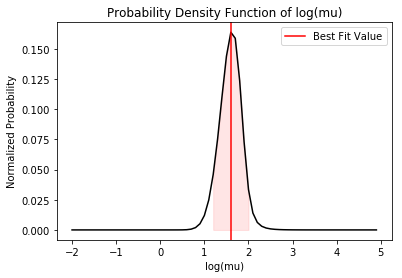

Best Fit log(mu) = 1.6000000000000032 ( 1.2000000000000028  -  2.0000000000000036 )


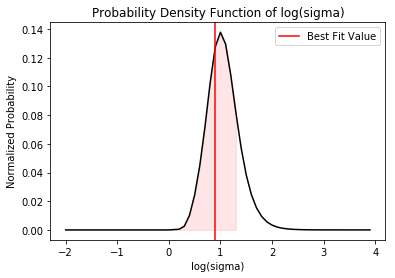

Best Fit log(sigma) = 0.9000000000000026 ( -2.0  -  1.300000000000003 )


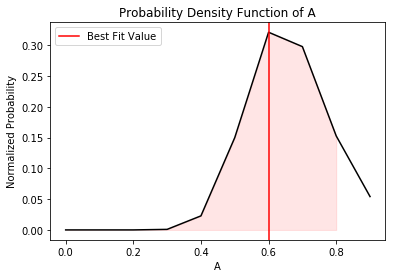

Best Fit A = 0.6000000000000001 ( 0.0  -  0.8 )


In [4]:
# this function takes in a list and returns the index of the list that is closest to any given number (used in pdf "error bars")
def closest(list, number):
    x = []
    for value in list:
        x.append(abs(number-value))
    return x.index(min(x))


# initializing proability cube
prob_cube = np.zeros([len(A_range),len(sigma_range),len(mu_range)]) # layers, rows, columns

# chi-squared probability formula
# def prob_chi(x):
#     return x ** ((nu-2)/2) * np.exp(-x/2)

# dont use prefactor 
# no prefactor
def prob_chi(x):
    return np.exp(-x/2)

# converting cube from reduced chi-squared values to probabilities (from chi-squared distribution)
for i in range(len(A_range)): # layers
    for j in range(len(sigma_range)): # columns
        for k in range(len(mu_range)): # rows
                prob_cube[i][j][k] = prob_chi(cube[i][j][k])

                
# The following code computes the 1-D pdf's of each of the three fit parameters. First, log(mu). Then, log(sigma) and finally A
      
    
# mu 1-D pdf

# collapsing cube to one dimension
sigmaxmu = np.sum(prob_cube, 0)
mu = np.sum(sigmaxmu, 0)

# normalizing pdf by summing values and multiplying by the amplitude that makes this sum equal to 1
area = sum(mu)
norm_const_mu = 1 / area
norm_mu = norm_const_mu * mu

# drawing "error bars" on the pdf: 
# a cumulative integration gives successive areas under the curve
area_under_1 = integrate.cumtrapz(norm_mu, initial=0)
range_index_1 = closest(mu_range, best_mu)
# 33% of the data on either side of the best fit value is highlighted
width_1 = .90
lower_1 = area_under_1[range_index_1] - (width_1 / 2)
upper_1 = area_under_1[range_index_1] + (width_1 / 2)
lower_index_1 = closest(area_under_1, lower_1)
upper_index_1 = closest(area_under_1, upper_1)

# Graphing
plt.plot(mu_range, norm_mu, color="black")
plt.title("Probability Density Function of log(mu)")
plt.xlabel("log(mu)")
plt.ylabel("Normalized Probability")
plt.axvline(x=best_mu, color="red", label = "Best Fit Value")
plt.legend()
plt.savefig("log(mu)_pdf")
# The following line highlights 66% of the data centered on the best fit value (found above)
plt.fill_between(mu_range[lower_index_1:upper_index_1+1], norm_mu[lower_index_1:upper_index_1+1], color="red", alpha=.1)
plt.show()

print("Best Fit log(mu) =", best_mu, "(", mu_range[lower_index_1], " - ", mu_range[upper_index_1], ")")



# sigma 1-D pdf

# collapsing cube to one dimension
sigmaxmu = np.sum(prob_cube, 0)
sigma = np.sum(sigmaxmu, 1)

# normalizing pdf by summing values and multiplying by the amplitude that makes this sum equal to 1
area = sum(sigma)
norm_const_sigma = 1 / area
norm_sigma = norm_const_sigma * sigma

# drawing "error bars" on the pdf: 
# a cumulative integration gives successive areas under the curve
area_under_2 = integrate.cumtrapz(norm_sigma, initial=0)
range_index_2 = closest(sigma_range, best_sigma)
# 33% of the data on either side of the best fit value is highlighted
width_2 = .90
lower_2 = area_under_2[range_index_2] - (width_2 / 2)
upper_2 = area_under_2[range_index_2] + (width_2 / 2)
lower_index_2 = closest(area_under_2, lower_2)
upper_index_2 = closest(area_under_2, upper_2)

# Graphing
plt.plot(sigma_range, norm_sigma, color="black")
plt.title("Probability Density Function of log(sigma)")
plt.xlabel("log(sigma)")
plt.ylabel("Normalized Probability")
plt.axvline(x=best_sigma, color="red", label = "Best Fit Value")
plt.legend()
plt.savefig("log(sigma)_pdf")
# The following line highlights 66% of the data centered on the best fit value (found above)
plt.fill_between(sigma_range[lower_index_2:upper_index_2+1], norm_sigma[lower_index_2:upper_index_2+1], color="red", alpha=.1)
plt.show()

print("Best Fit log(sigma) =", best_sigma, "(", sigma_range[lower_index_2], " - ", sigma_range[upper_index_2], ")")



# A 1-D pdf

# collapsing cube to one dimension
Axsigma = np.sum(prob_cube, 2)
A = np.sum(Axsigma, 1)

# normalizing pdf by summing values and multiplying by the amplitude that makes this sum equal to 1
area = sum(A)
norm_const_A = 1 / area
norm_A = norm_const_A * A

# drawing "error bars" on the pdf: 
# a cumulative integration gives successive areas under the curve
area_under_3 = integrate.cumtrapz(norm_A, initial=0)
range_index_3 = closest(A_range, best_A)
# 33% of the data on either side of the best fit value is highlighted
width_3 = .90
lower_3 = area_under_3[range_index_3] - (width_3 / 2)
upper_3 = area_under_3[range_index_3] + (width_3 / 2)
lower_index_3 = closest(area_under_3, lower_3)
upper_index_3 = closest(area_under_3, upper_3)

# Graphing
plt.plot(A_range, norm_A, color="black")
plt.title("Probability Density Function of A")
plt.xlabel("A")
plt.ylabel("Normalized Probability")
plt.axvline(x=best_A, color="red", label = "Best Fit Value")
# The following line highlights 66% of the data centered on the best fit value (found above)
plt.fill_between(A_range[lower_index_3:upper_index_3+1], norm_A[lower_index_3:upper_index_3+1], color="red", alpha=.1)
plt.legend()
plt.savefig("A_pdf")
plt.show()

print("Best Fit A =", best_A, "(", A_range[lower_index_3], " - ", A_range[upper_index_3], ")")

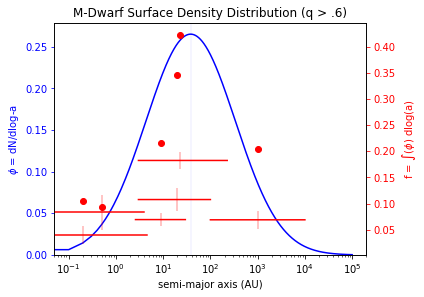

In [5]:
a = np.linspace(0, 1e5, 1e6)
x = np.log10(a)
best_A = 0.629
best_mu = 1.582
best_sigma = 0.946
pdf = best_A * log_normal_pdf(x, best_mu, best_sigma)


fig, ax1 = plt.subplots()
ax1.plot(a, pdf, 'b-')
ax1.set_xlabel('semi-major axis (AU)')
ax1.set_ylabel(r'$\phi$ = dN/dlog-a', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(0)
ax1.axvline(10**best_mu, color = "b", alpha = .05)
# ax1.annotate(('log(mu) =' best_mu), xy=(1, .22), xytext=(1, .22))
# ax1.annotate(('log(sigma) = ' best_sigma), xy=(1, .20), xytext=(1, .20))
# ax1.annotate('A =', best_A, xy=(1, .18), xytext=(1, .18))

ax2 = ax1.twinx()
ax2.set_ylabel(r'f = $\int(\phi)$ dlog(a)', color='r')
CC_domain = []
CC_range = np.arange(d.min_sep_limit_CC,d.max_sep_limit_CC,.01)
for i in range(len(CC_range)):
    CC_domain.append(d.f_CC)
Del_domain = []
Del_range = np.arange(d.min_sep_limit_Del,d.max_sep_limit_Del,.01)
for i in range(len(Del_range)):
    Del_domain.append(d.f_Del)    
Jan_domain = []
Jan_range = np.arange(d.min_sep_limit_Jan,d.max_sep_limit_Jan,.01)
for i in range(len(Jan_range)):
    Jan_domain.append(d.f_Jan)
FM_domain = []
FM_range = np.arange(d.min_sep_limit_FM,d.max_sep_limit_FM,.01)
for k in range(len(FM_range)):
    FM_domain.append(d.f_FM)
# WD_domain = []
# WD_range = np.arange(d.min_sep_limit_WD,d.max_sep_limit_WD,.01)
# for k in range(len(WD_range)):
#     WD_domain.append(d.f_WD) 
WD_A_domain = []
WD_A_range = np.arange(d.min_sep_limit_WD_A,d.max_sep_limit_WD_A,.01)
for k in range(len(WD_A_range)):
    WD_A_domain.append(d.f_WD_A)  
WD_B_domain = []
WD_B_range = np.arange(d.min_sep_limit_WD_B,d.max_sep_limit_WD_B,.01)
for k in range(len(WD_B_range)):
    WD_B_domain.append(d.f_WD_B)  
# SV_domain = []
# SV_range = np.arange(d.min_sep_limit_SV,d.max_sep_limit_SV,.01)
# for k in range(len(SV_range)):
#     SV_domain.append(d.f_SV)

# ax2.annotate('CC', xy=(1.5, d.f_CC))
# ax2.annotate('Del', xy=(.05, d.f_Del))
# ax2.annotate('Jan', xy=(1.5, d.f_Jan))
# ax2.annotate('FM', xy=(.05, d.f_FM))
# # ax2.annotate('WD', xy=(3, d.f_WD))
# ax2.annotate('WD_A', xy=(1.5, d.f_WD_A))
# ax2.annotate('WD_B', xy=(100, d.f_WD_B))
# # ax2.annotate('SV', xy=(.7, d.f_SV-.005))
    
ax2.plot(CC_range,CC_domain, color="red")
ax2.plot(Del_range,Del_domain, color="red")
ax2.plot(Jan_range,Jan_domain, color="red")
ax2.plot(FM_range,FM_domain, color="red")
# ax2.plot(WD_range,WD_domain, color="red")
ax2.plot(WD_A_range,WD_A_domain, color="red")
ax2.plot(WD_B_range,WD_B_domain, color="red")
# ax2.plot(SV_range,SV_domain, color="red")

ax2.tick_params('y', colors='r')

# ax2.errorbar(np.mean(CC_range), d.f_CC, yerr = d.e_CC, xerr = None, ecolor = 'red', alpha = .3, linestyle = "--")
# ax2.errorbar(np.mean(Jan_range), d.f_Jan, yerr = d.e_Jan, xerr = None, ecolor = 'red', alpha = .3)
# ax2.errorbar(np.mean(WD_range), d.f_WD, yerr = d.e_WD, xerr = None, ecolor = 'red', alpha = .3)
# ax2.errorbar(np.mean(FM_range), d.f_FM, yerr = d.e_FM, xerr = None, ecolor = 'red', alpha = .3)
# ax2.errorbar(np.mean(SV_range), d.f_SV, yerr = d.e_SV, xerr = None, ecolor = 'red', alpha = .3)
# ax2.errorbar(np.mean(Del_range), d.f_Del, yerr = d.e_Del, xerr = None, ecolor = 'red', alpha = .3)

test_int_CC = integrate.quad(lambda x: log_normal_pdf(x, best_mu, best_sigma) , np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC))
test_int_Del = integrate.quad(lambda x: log_normal_pdf(x, best_mu, best_sigma) , np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del))
test_int_Jan = integrate.quad(lambda x: log_normal_pdf(x, best_mu, best_sigma) , np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan))
test_int_FM = integrate.quad(lambda x: log_normal_pdf(x, best_mu, best_sigma) , np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM))
# test_int_WD = integrate.quad(lambda x: log_normal_pdf(x, best_mu, best_sigma) , np.log10(d.min_sep_limit_WD), np.log10(d.max_sep_limit_WD))   
test_int_WD_A = integrate.quad(lambda x: log_normal_pdf(x, best_mu, best_sigma) , np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A))   
test_int_WD_B = integrate.quad(lambda x: log_normal_pdf(x, best_mu, best_sigma) , np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B))   
# test_int_SV = integrate.quad(lambda x: log_normal_pdf(x, best_mu, best_sigma) , np.log10(d.min_sep_limit_SV), np.log10(d.max_sep_limit_SV))

test_CC = best_A * test_int_CC[0]
test_Del = best_A * test_int_Del[0]
test_Jan = best_A * test_int_Jan[0]
test_FM = best_A * test_int_FM[0]
# test_WD = best_A * test_int_WD[0]
test_WD_A = best_A * test_int_WD_A[0]
test_WD_B = best_A * test_int_WD_B[0]
# test_SV = best_A * test_int_SV[0]

ax2.scatter(9, test_CC, color = "red")
ax2.scatter(23, test_Jan, color = "red")
# ax2.scatter(20, test_WD, color = "red")
ax2.scatter(20, test_WD_A, color = "red")
ax2.scatter(1000, test_WD_B, color = "red")
ax2.scatter(.5, test_FM, color = "red")
# ax2.scatter(4, test_SV, color = "red")
ax2.scatter(.2, test_Del, color = "red")

ax2.errorbar(9, d.f_CC, yerr = d.e_CC, xerr = None, ecolor = 'red', alpha = .3)
ax2.errorbar(23, d.f_Jan, yerr = d.e_Jan, xerr = None, ecolor = 'red', alpha = .3)
# ax2.errorbar(20, d.f_WD, yerr = d.e_WD, xerr = None, ecolor = 'red', alpha = .3)
ax2.errorbar(20, d.f_WD_A, yerr = d.e_WD_A, xerr = None, ecolor = 'red', alpha = .3)
ax2.errorbar(1000, d.f_WD_B, yerr = d.e_WD_B, xerr = None, ecolor = 'red', alpha = .3)
ax2.errorbar(.5, d.f_FM, yerr = d.e_FM, xerr = None, ecolor = 'red', alpha = .3)
# ax2.errorbar(4, d.f_SV, yerr = d.e_SV, xerr = None, ecolor = 'red', alpha = .3)
ax2.errorbar(.2, d.f_Del, yerr = d.e_Del, xerr = None, ecolor = 'red', alpha = .3)

fig.tight_layout()
plt.xscale('log')
plt.title("M-Dwarf Surface Density Distribution (q > .6)")
# plt.savefig('result.jpg')
plt.show()

0.23602568103188665


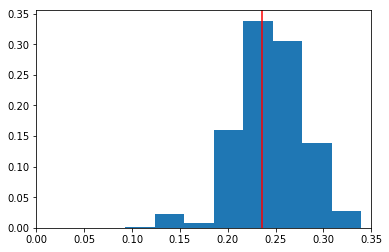

-0.33979172970536575 0.029029437664772634 0.3397917297053658


In [33]:
# f analysis

best_dq = integrate.quad(lambda q: q**.25 , .6, 1)
best_dloga = integrate.quad(lambda x: log_normal_pdf(x, best_mu, best_sigma) , np.log10(0.04), np.log10(10000))
best_f = best_A * best_dq[0] * best_dloga[0]
print(best_f)

prob = np.reshape(prob_cube, len(mu_range) * len(sigma_range) * len(A_range))
norm_const = (1 / sum(prob))
norm_prob = norm_const * prob

f = np.reshape(f_cube, len(mu_range) * len(sigma_range) * len(A_range))

plt.hist(f, weights = norm_prob, bins = 22)
plt.axvline(x = .236, color = "red")
plt.xlim(0, .35)
plt.show()

print(min(f), np.mean(f), max(f))

# plt.hist(f)
# plt.show()